In [1]:
import os

In [2]:
import rospy


from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import Quaternion, Point, Pose, PoseArray, PoseStamped
from sensor_msgs.msg import LaserScan
from std_msgs.msg import Header, String

import numpy as np
from numpy.random import random_sample
import math

from random import randint, random

In [3]:
import pickle


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# ODOM MODEL

In [5]:
prev_pose = Pose()
curr_pose = Pose()

In [6]:
prev_pose.position.x=-2.3256815457461357
prev_pose.position.y=3.3306116066751175
prev_pose.position.z=-0.0010009972721040513

prev_pose.orientation.x=-0.0035189548631042373
prev_pose.orientation.y=0.0015636272992440958
prev_pose.orientation.z=0.9134982750439026
prev_pose.orientation.w=0.4068243767501582

In [7]:
curr_pose.position.x=-2.542247393211534
curr_pose.position.y=3.4052486937156976
curr_pose.position.z=-0.0010014737656640397
curr_pose.orientation.x=-0.0036902484366300226
curr_pose.orientation.y=0.0011109290348179797
curr_pose.orientation.z=0.9570636879904949
curr_pose.orientation.w=0.28985210889898394

In [8]:
import numpy as np

def quaternion_to_euler_angle_vectorized(w, x, y, z):
    ysqr = y * y
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))
    Z = np.arctan2(t3, t4)


    return Z 

In [9]:
def fetch_short_coordinates(pose_obj):
        ans = [pose_obj.position.x, pose_obj.position.y, 0]
        Z = quaternion_to_euler_angle_vectorized(
                                        pose_obj.orientation.w,
                                        pose_obj.orientation.x,
                                        pose_obj.orientation.y,
                                        pose_obj.orientation.z
                                        )
        ans[2]=Z
        
        return ans

In [10]:
ans = fetch_short_coordinates(curr_pose)

In [11]:
ans

[-2.542247393211534, 3.4052486937156976, 2.55344348720384]

In [12]:
def fetch_new_pose(org_pose, new_short):
    org_pose.position.x = new_short[0]
    org_pose.position.y = new_short[1]
    
    
    org_pose.orientation.x = 0
    org_pose.orientation.y = 0
    org_pose.orientation.z = np.sin(new_short[2]/2)
    org_pose.orientation.w = np.cos(new_short[2]/2)
    return org_pose

In [13]:
ans2 = fetch_new_pose(curr_pose, ans)

In [14]:
ans2

position: 
  x: -2.542247393211534
  y: 3.4052486937156976
  z: -0.0010014737656640397
orientation: 
  x: 0
  y: 0
  z: 0.9570707881255247
  w: 0.289854284972272

In [15]:
curr_pose

position: 
  x: -2.542247393211534
  y: 3.4052486937156976
  z: -0.0010014737656640397
orientation: 
  x: 0
  y: 0
  z: 0.9570707881255247
  w: 0.289854284972272

In [16]:
import math

#### plot the initial points

In [17]:
Z1 = quaternion_to_euler_angle_vectorized(
    curr_pose.orientation.w,
    curr_pose.orientation.x,
    curr_pose.orientation.y,
    curr_pose.orientation.z
                                        )

In [18]:
Z2 = quaternion_to_euler_angle_vectorized(
    prev_pose.orientation.w,
    prev_pose.orientation.x,
    prev_pose.orientation.y,
    prev_pose.orientation.z
)

In [19]:
Z1, Z2

(2.55344348720384, 2.3036359071321795)

In [20]:
np.degrees(Z1) - np.degrees(Z2)

14.312920028482523

In [21]:
alpha_1 = 0.01
alpha_2 = 0
alpha_3 = 0.01
alpha_4 = 0.01

In [22]:
alpha_1 = 0.001
alpha_2 = 0.0001
alpha_3 = 0.001
alpha_4 = 0.0001

In [23]:
def sample_motion_model_odometry(prev_loc, current_loc, hyp_loc, print_stuff=False):
    dx = current_loc[0] - prev_loc[0]
    dy = current_loc[1] - prev_loc[1]
    dtheta = current_loc[2] - prev_loc[2]
        
    drot1 = math.atan2(dy, dx) - prev_loc[2]
    dtrans = math.sqrt(dx*dx+dy*dy)
    drot2 = dtheta - drot1
    
    if print_stuff:
        print("Stats are: ")
        print("Initial rotation 1 (deg) is: ", np.degrees(drot1), drot1)
        print("Init translation is: ", dtrans)
        print("Initial rotation 2 (deg) is ", np.degrees(drot2), drot2)
    
    var1 = alpha_1*math.fabs(drot1) + alpha_2*math.fabs(dtrans)
    std1 = math.sqrt(var1)
    #std1 = var1

    
    var2 = alpha_3*math.fabs(dtrans) + alpha_4 * math.fabs((drot1+drot2))
    std2 = math.sqrt(var2)
    #std2 = var2
    
    var3 = alpha_1*math.fabs(drot2) + alpha_2 * math.fabs(dtrans)
    std3 = math.sqrt(var3)
    #std3 = var3
    
    if print_stuff:
        print("vars are ", var1, var2, var3)
        print("Std dev are ", std1, std2, std3)
    
    #dr1 = np.random.normal(0, std1, 1)[0]
    #dt = np.random.normal(0, std2, 1)[0]
    #dr2 = np.random.normal(0, std3, 1)[0]
    
    dr1 = std1 * np.random.normal(0, 1, 1)[0]
    dt = std2* np.random.normal(0, 1, 1)[0]
    dr2 =std3 *  np.random.normal(0, 1, 1)[0]
    
    drot1_actual = drot1 - dr1
    dtrans_actual = dtrans - dt
    drot2_actual = drot2 - dr2
    
    if print_stuff:
        print("dr1 degrees ", np.degrees(dr1), dr1)
        print("dt  ", dt)
        print("dr2 degrees ", np.degrees(dr2), dr2)
    
    if print_stuff:
        print("Stats are: ")
        print("Rot 1: degrees: ", np.degrees(drot1), np.degrees(drot1_actual))
        print(dtrans, dtrans_actual)
        print("Rot 2: degrees: ", np.degrees(drot2), np.degrees(drot2_actual))
    
    ans_x = hyp_loc[0] + dtrans_actual * math.cos(hyp_loc[2]+drot1_actual)
    ans_y = hyp_loc[1] + dtrans_actual * math.sin(hyp_loc[2]+drot1_actual)
    ans_theta = hyp_loc[2] + drot1_actual + drot2_actual
    return [ans_x, ans_y, ans_theta]

## Experiment 1: Only translation

In [24]:
prev_loc = [0, 0, np.pi/4]

In [25]:
curr_loc = [0.5, 0.502, np.pi/4]

In [26]:
curr_loc

[0.5, 0.502, 0.7853981633974483]

In [27]:
sample_motion_model_odometry(prev_loc, curr_loc, prev_loc, True)

Stats are: 
Initial rotation 1 (deg) is:  0.11436268148414606 0.001996005333307904
Init translation is:  0.7085224061382956
Initial rotation 2 (deg) is  -0.11436268148414606 -0.001996005333307904
vars are  7.284824594713747e-05 0.0007085224061382957 7.284824594713747e-05
Std dev are  0.008535118390926834 0.02661808419361348 0.008535118390926834
dr1 degrees  0.719651513074395 0.012560288370107213
dt   -0.033050121215564
dr2 degrees  1.384556649273862 0.024165072210209245
Stats are: 
Rot 1: degrees:  0.11436268148414606 -0.6052888315902489
0.7085224061382956 0.7415725273538596
Rot 2: degrees:  -0.11436268148414606 -1.498919330758008


[0.5298812023651247, 0.5188022019094374, 0.7486728028171318]

In [28]:
ans = [sample_motion_model_odometry(prev_loc, curr_loc, prev_loc) for i in range(500)]

In [29]:
ans

[[0.4918424332312716, 0.48151808267780755, 0.772272369047369],
 [0.509700421583988, 0.5135477215066124, 0.7934052174151532],
 [0.5108531152862249, 0.5133764772093129, 0.7933457301726212],
 [0.5139176070235992, 0.5345228984286736, 0.8105143085938039],
 [0.5072081410805457, 0.5010539213254814, 0.8023161073915672],
 [0.5003634612458028, 0.5130735013278457, 0.8016914334455755],
 [0.5055250024334773, 0.5185529111791467, 0.810488127373948],
 [0.5255369797651731, 0.5133123617888623, 0.760434405135792],
 [0.5137586347552989, 0.49976059744753587, 0.7628537049312871],
 [0.4750579123283279, 0.48682559798968256, 0.7941806897997483],
 [0.5034887827207196, 0.5059650641858983, 0.7633645128035121],
 [0.5281446895185297, 0.525418157551213, 0.7976182570432503],
 [0.508000356431764, 0.5050643374485392, 0.7761093487715032],
 [0.5124093337089101, 0.5185093264912766, 0.7834208684651827],
 [0.5039601005210441, 0.4889960441358677, 0.7647137302852911],
 [0.4724200948511898, 0.48014406065869675, 0.7838923949715

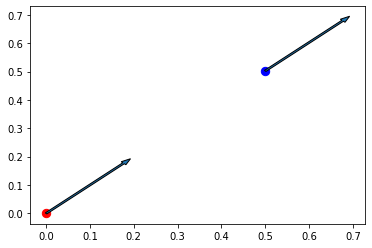

In [30]:

plt.scatter([prev_loc[0]], [prev_loc[1]], color='r', s=70)
plt.scatter([curr_loc[0]], [curr_loc[1]], color='b', s=70)

plt.arrow(curr_loc[0], curr_loc[1], 0.25*np.cos(curr_loc[2]), 0.25*np.sin(curr_loc[2]), width = 0.005)
plt.arrow(prev_loc[0], prev_loc[1], 0.25*np.cos(prev_loc[2]), 0.25*np.sin(prev_loc[2]), width = 0.005)

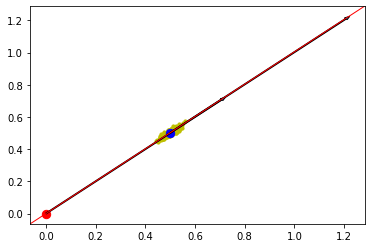

In [31]:
x_arr = [x[0] for x in ans]
y_arr = [x[1] for x in ans]
plt.scatter(x_arr,y_arr, color='y', s=10)

plt.scatter([prev_loc[0]], [prev_loc[1]], color='r', s=70)
plt.scatter([curr_loc[0]], [curr_loc[1]], color='b', s=70)

plt.arrow(curr_loc[0], curr_loc[1], 1*np.cos(curr_loc[2]), 1*np.sin(curr_loc[2]), width = 0.005)
plt.arrow(prev_loc[0], prev_loc[1], 1*np.cos(prev_loc[2]), 1*np.sin(prev_loc[2]), width = 0.005)
plt.axline((prev_loc[0], prev_loc[1]), (curr_loc[0], curr_loc[1]), linewidth=1, color='r')

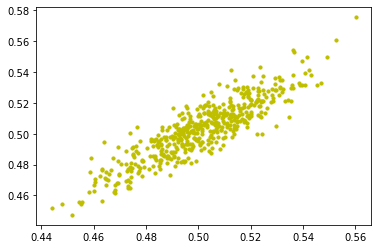

In [32]:
x_arr = [x[0] for x in ans]
y_arr = [x[1] for x in ans]
plt.scatter(x_arr,y_arr, color='y', s=10)

## Experiment 2: Rotation + Translation

In [33]:
prev_loc = [0, 0, 0]

In [34]:
curr_loc = [5, 5, np.pi/3]

In [35]:
curr_loc

[5, 5, 1.0471975511965976]

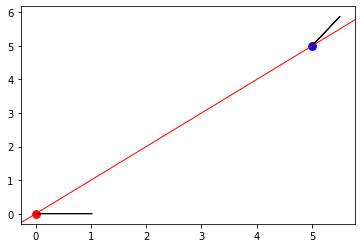

In [36]:
plt.scatter([prev_loc[0]], [prev_loc[1]], color='r', s=60)
plt.scatter([curr_loc[0]], [curr_loc[1]], color='b', s=60)
plt.arrow(curr_loc[0], curr_loc[1], 1*np.cos(curr_loc[2]), 1*np.sin(curr_loc[2]), width = 0.005)
plt.arrow(prev_loc[0], prev_loc[1], 1*np.cos(prev_loc[2]), 1*np.sin(prev_loc[2]), width = 0.005)
plt.axline((prev_loc[0], prev_loc[1]), (curr_loc[0], curr_loc[1]), linewidth=1, color='r')

In [37]:
sample_motion_model_odometry(prev_loc, curr_loc, prev_loc, True)

Stats are: 
Initial rotation 1 (deg) is:  45.0 0.7853981633974483
Init translation is:  7.0710678118654755
Initial rotation 2 (deg) is  14.999999999999996 0.26179938779914935
vars are  0.001492504944583996 0.007175787566985135 0.000968906168985697
Std dev are  0.03863295153860233 0.08471002046384557 0.031127257652830535
dr1 degrees  0.14163788634269503 0.0024720474622455376
dt   0.05764079203475426
dr2 degrees  -0.04601124463379186 -0.0008030477118002405
Stats are: 
Rot 1: degrees:  45.0 44.85836211365731
7.0710678118654755 7.013427019830721
Rot 2: degrees:  14.999999999999996 15.046011244633787


[4.971486120709977, 4.946967183444793, 1.0455285514461523]

In [38]:
ans = [sample_motion_model_odometry(prev_loc, curr_loc, prev_loc) for i in range(500)]

In [39]:
ans

[[4.919513227998172, 5.123820724525549, 1.0819517352920935],
 [4.901014752893869, 5.100105613808968, 1.0609507472066126],
 [5.059176832784371, 4.790443873425406, 0.9868608706760548],
 [5.392975336362829, 4.862481800386462, 1.0222275928067233],
 [5.206487706477348, 4.789808622499563, 1.042084612144191],
 [5.164719262294449, 4.923055280007443, 1.0739896453423796],
 [4.830332331659478, 5.253736755774872, 1.0760786713418353],
 [5.145626031805509, 4.831996066149429, 1.0441738430585592],
 [5.32043528507498, 4.570662320843115, 0.9624152395619814],
 [5.087722887746628, 5.13605428572569, 1.0744463671278637],
 [5.222378969860889, 4.6840800624911845, 0.9706909188644578],
 [5.049007096281642, 4.890487597928729, 0.9960209040321829],
 [4.970869040910905, 4.910989260555452, 1.0683280392188583],
 [5.244390960302382, 4.823035820483424, 1.0191825308577318],
 [5.097924581689822, 4.801143940798954, 1.0161662320264002],
 [4.695219784372133, 5.24050062034669, 1.0884379785800573],
 [4.903844920513202, 5.1612

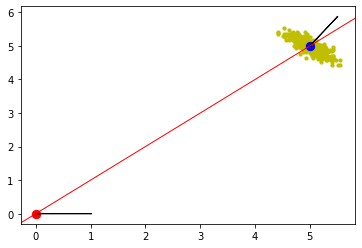

In [40]:
x_arr = [x[0] for x in ans]
y_arr = [x[1] for x in ans]
plt.scatter(x_arr,y_arr, color='y', s=10)

plt.scatter([prev_loc[0]], [prev_loc[1]], color='r', s=70)
plt.scatter([curr_loc[0]], [curr_loc[1]], color='b', s=70)

plt.arrow(curr_loc[0], curr_loc[1], 1*np.cos(curr_loc[2]), 1*np.sin(curr_loc[2]), width = 0.005)
plt.arrow(prev_loc[0], prev_loc[1], 1*np.cos(prev_loc[2]), 1*np.sin(prev_loc[2]), width = 0.005)
plt.axline((prev_loc[0], prev_loc[1]), (curr_loc[0], curr_loc[1]), linewidth=1, color='r')

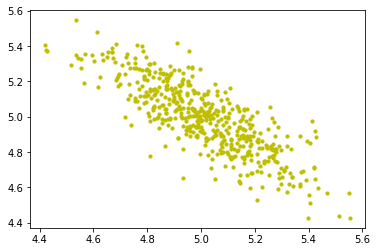

In [41]:
x_arr = [x[0] for x in ans]
y_arr = [x[1] for x in ans]
plt.scatter(x_arr,y_arr, color='y', s=10)